In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from collections import Counter
from collections import defaultdict
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
import torch.nn as nn
import time
import os
import torch
import copy
import torch.nn.functional as F
import wandb
import json
import heapq
import pandas as pd
import pickle



# Seeds for reproducibility
def set_seeds(seed: int = 123):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
""" PLOT SETTINGS """

plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "font.size": 18,            # base font size
    "axes.titlesize": 24,       # axis titles
    "axes.labelsize": 22,       # axis labels
    "xtick.labelsize": 18,      # X axis numbers
    "ytick.labelsize": 18,      # Y axis numbers
    "legend.fontsize": 18,      # legend text
    "lines.linewidth": 3.0      # line thickness
})


In [ ]:
# --- Define DINOWithHead ---
class DINOWithHead(nn.Module):
    def __init__(self, backbone, num_classes=100, p=None):
        super().__init__()
        self.backbone = backbone
        layers = []
        if p is not None:
            layers.append(nn.Dropout(p=p))
        layers.append(nn.Linear(384, num_classes))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out

## Data import and loader creation

In [ ]:
""" DATASET DOWNLOAD """
ROOT = './data'
BATCH_SIZE=64
#BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=True, transform=torchvision.transforms.ToTensor())





""" SPLIT TOT_TRAININ in VALIDATION and TRAIN """

def split_dataset(tot_train_data, valid_ratio=0.8):
    """
    Splits the given dataset randomly into training and validation subsets
    """
    train_size = int(valid_ratio * len(tot_train_data))
    val_size = len(tot_train_data) - train_size
    train_data, val_data = random_split(tot_train_data, [train_size, val_size])
    return train_data, val_data

train_data, val_data = split_dataset(tot_train_data, valid_ratio=0.8)



""" DATA TRANSFORMATION """

def data_trasform(dataset, data_augmentation=False):   ### train_data or tot_train_data
    """
    Returns train and val/test transforms based on dataset stats.
    Dataset (for computing mean and std) can be either training only or combined train+validation.

    If data_augmentation=True, applies augmentation on training transforms, otherwise only resize and normalize.
    """

    # MEAN and VARIANCE (considering 3 channels)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten H*W
        mean += img.mean(1)
        std += img.std(1)
        nb_samples += 1

    mean /= nb_samples
    std /= nb_samples


    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomCrop(64, padding=4),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.RandAugment(num_ops=2, magnitude=9),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    ### NO DATA AUGMENTATION!
    val_test_transforms = transforms.Compose([
        transforms.Resize(64),                    # Resize
        transforms.ToTensor(),                     # Convert to tensor
        transforms.Normalize(mean=mean, std=std)   # Normalization using the training statistics
    ])


    return train_transforms, val_test_transforms






""" DATA TRANSFORMATION and LOADERS """

### ===== For hyperparameter tuning considering train_data and val_data =====
train_transforms, val_test_transforms = data_trasform(train_data)

train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_test_transforms

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



### ===== For model testing considering tot_train_data and test_data =====
train_transforms, val_test_transforms = data_trasform(tot_train_data)

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=False, transform=train_transforms)
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=False, transform=val_test_transforms)

tot_train_loader = DataLoader(tot_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Functions Client

In [ ]:
""" SPLIT INTO K CLIENTS: iid and non-iid distributions  """

def iid_shard(dataset, K):
    """
    Splits the dataset into K disjoint subsets (one per client) in an IID fashion. Each client receives ~len(dataset)/K samples,
    drawn uniformly at random across all classes.
    """
    num_items_per_client = len(dataset) // K
    remainder = len(dataset) % K
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)

    client_data = {}  # Creation of a dictionary for clients
    start = 0
    for i in range(K):
        # give +1 to the first `remainder` clients
        add = num_items_per_client + (1 if i < remainder else 0)
        end = start + add
        client_data[i+1] = Subset(dataset, all_indices[start:end])
        start = end

    return client_data


def noniid_shard(dataset, K, Nc):
    """
    Splits the dataset into K disjoint subsets (one per client) in a non-IID fashion.
    Disjoint dataset: each sample must belong to exactly one client and cannot be duplicated.
    Nc: each client receives samples from Nc distinct classes, to simulate variability of data across clients.
    """
    # === Feasibility check ===
    all_classes = set(label for _, label in dataset)
    num_classes = len(all_classes)
    if Nc > num_classes:
        raise ValueError(f"Cannot assign {Nc} classes per client: only {num_classes} classes available.")


    # === Step 1: Organize data by class ===
    # This ensures we can select samples from specific classes without duplication.
    label_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)    # key: class, value: list of idxs of the corresponding class

    # === Step 2: Shuffle samples within each class ===
    # Prevents consecutive samples from going to the same clients repeatedly.
    for cls in label_to_indices:
        random.shuffle(label_to_indices[cls])

    # === Step 3: Prepare the list of clients and shuffle it ===
    # Guarantees random assignment of classes to clients.
    all_classes = list(label_to_indices.keys())

    client_class_map = {}
    for client_id in range(1, K+1):        # Pre-select Nc classes per client at the beginning.
        client_class_map[client_id] = random.sample(all_classes, Nc)

    client_data = {cid: [] for cid in range(1, K+1)}    # Initialize empty client datasets
    class_to_clients = defaultdict(list)     # For each class, keep track of clients that have it (reverse map from class → clients that have that class)
    for cid, classes in client_class_map.items():
        for cls in classes:
            class_to_clients[cls].append(cid)


    # === Step 4: Distribute samples in rounds ===
    # Distributing samples to clients in rounds
    for cls, indices in label_to_indices.items():    # Iterate over all classes, where indices is the list of the samples for the considered class
        clients = class_to_clients[cls]  # clients that want this class
        if not clients:
            continue
        i = 0
        while indices:
            client_id = clients[i % len(clients)]  # cycling continuously through the list of clients
            sample = indices.pop()                 # take one sample and it removes it so it will not be repeated
            client_data[client_id].append(sample)  # assign to this client
            i += 1

     # === Step 5: Convert sample index lists into Subsets ===
    for cid in client_data:
        client_data[cid] = Subset(dataset, client_data[cid])

    return client_data

## Class Client

In [ ]:
def compress_mask(mask_dict):
    """
    Convert each 0/1 tensor in the mask into a compressed bit array.
    Returns a dictionary: {param_name: (packed_uint8_array, original_shape)}
    """
    compressed = {}
    for name, tensor in mask_dict.items():
        # Move tensor to CPU, cast to uint8, flatten, and convert to numpy
        arr = tensor.detach().to('cpu').to(torch.uint8).contiguous().view(-1).numpy()
        # Pack bits into a compact representation (8x smaller than uint8)
        packed = np.packbits(arr)
        compressed[name] = (packed, tuple(tensor.shape))  # store packed data + original shape
    return compressed


def decompress_mask(compressed_dict):
    """
    Reconstruct torch.uint8 tensors with the original shape (0/1 values).
    """
    mask = {}
    for name, (packed, shape) in compressed_dict.items():
        total = int(np.prod(shape))  # number of elements in original tensor
        # Unpack bits back to 0/1 and trim extra padding
        unpacked = np.unpackbits(packed)[:total]
        # Reshape to original tensor shape and convert to torch.uint8
        mask[name] = torch.from_numpy(unpacked.reshape(shape)).to(torch.uint8)
    return mask



""" CLASS CLIENT"""
class Client:
    def __init__(self, client_id, dataset, loader,
                 mask=None, extra_mask=None, fisher_scores=None,
                 local_weights=None, compressed_mask=None):
        self.client_id = client_id
        self.dataset = dataset
        self.loader = loader

        # Full mask in RAM (0/1 tensors) – only needed during training
        self.mask = mask

        # Lightweight storage version (bit-packed mask)
        self.compressed_mask = compressed_mask

        # Optional: additional mask (depends on your logic)
        self.extra_mask = extra_mask

        # Fisher scores are only needed during calibration;
        # after that, you can set them to None to save memory
        self.fisher_scores = fisher_scores

        # Local weights are not really used in your training loop;
        # kept here only for compatibility
        self.local_weights = local_weights

    def compress_mask(self):
        """
        Compress self.mask into self.compressed_mask and free RAM
        """
        if self.mask is not None:
            # Make sure mask tensors are uint8 (0/1 values)
            self.mask = {k: v.to(torch.uint8) for k, v in self.mask.items()}
            self.compressed_mask = compress_mask(self.mask)
            self.mask = None  # release memory

    def decompress_mask(self):
        """
        Rebuild self.mask (0/1 tensors) from self.compressed_mask
        """
        if self.compressed_mask is not None and self.mask is None:
            self.mask = decompress_mask(self.compressed_mask)



    def num_samples(self):
        """
        Returns the number of samples in the client’s local dataset.
        """
        return len(self.dataset)

    @staticmethod
    def print_samples(clients):
        """
        Prints the number of samples each client holds.
        """
        print("Number of samples per client:")
        for client in clients:
            print(f"Client {client.client_id}: {client.num_samples()} samples")

    @staticmethod
    def plot_class_distribution(clients, dataset):
        """
        Plots the distribution of classes for a list of clients.
        """
        class_distributions = []

        if hasattr(dataset, 'targets'):
            get_label = lambda idx: dataset.targets[idx]
        elif hasattr(dataset, 'labels'):
            get_label = lambda idx: dataset.labels[idx]
        else:
            get_label = lambda idx: dataset[idx][1]

        for client in clients:
            indices = client.loader.dataset.indices if isinstance(client.loader.dataset, Subset) else list(range(len(client.loader.dataset)))
            labels = [get_label(i) for i in indices]
            class_counts = Counter(labels)
            class_distributions.append(class_counts)

        fig, axes = plt.subplots(nrows=1, ncols=len(clients), figsize=(5 * len(clients), 4))
        if len(clients) == 1:
            axes = [axes]

        for i, (client, class_counts) in enumerate(zip(clients, class_distributions)):
            axes[i].bar(class_counts.keys(), class_counts.values(), color='orange')
            axes[i].set_title(f'Client {client.client_id}')
            axes[i].set_xlabel('Classes')
            axes[i].set_ylabel('Frequency')
            axes[i].set_xticks(list(class_counts.keys()))

        plt.tight_layout()
        plt.show()



""" CLIENT CREATION """
def create_clients(data, K, Nc=None, flag = "iid"):   ### data is either train_data or tot_data
    """
    Splits the dataset into K subsets, either IID or non-IID, and returns both the client datasets and their corresponding DataLoaders
    """
    if flag == "iid":     # We want iid
      client_datasets = iid_shard(data, K)     # Split the training data into K clients

    else:    # We want non iid
      client_datasets = noniid_shard(data, K, Nc)

    client_loaders = {}    ### Creation of a DataLoader for each client

    for client_id, subset in client_datasets.items():
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
        client_loaders[client_id] = loader       # The clients id are the indices+1
    return client_datasets, client_loaders


def create_client_objects(data, K, Nc=None, flag="iid", batch_size=64, verbose=True):
    """
    Creates and returns a list of Client objects, each containing its own dataset and DataLoader, ready for use in federated learning
    """

    # === CHECK ===
    if flag == "non-iid" and Nc is None:
        raise ValueError("Nc must be set when flag='non-iid'")

    client_datasets, client_loaders = create_clients(data, K, Nc, flag=flag)
    clients = []
    for client_id in client_datasets.keys():
        clients.append(Client(client_id, client_datasets[client_id], client_loaders[client_id]))


    if verbose:
        print("Clients and their sample sizes:")
        for client in clients:
            print(f"Client {client.client_id}: {client.num_samples()} samples")

    return clients


## Server model evaluation

In [ ]:
""" MODEL EVALUATION """
def evaluate_model(model, data_loader, criterion):
    """
    The evaluate_model function computes the average loss and accuracy of a model on a dataset without updating its weights.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds == labels.data)

    avg_loss = total_loss / len(data_loader.dataset)
    avg_acc = total_corrects.double() / len(data_loader.dataset)

    return avg_loss, avg_acc.item()



In [ ]:
""" CHECKPOINT FUNCTION """
def save_checkpoint(model, epoch, train_losses, train_accuracies,
                    val_test_losses, val_test_accuracies, best_acc, best_loss, best_model_wts, path):
    """
    The save_checkpoint function saves the model’s state, training/validation metrics,
    and best performance to a specified file path.
    """
    dir_name = os.path.dirname(path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_test_losses': val_test_losses,
        'val_test_accuracies': val_test_accuracies,
        'best_acc': best_acc,
        'best_loss': best_loss,
        'best_model_state_dict': best_model_wts
    }
    torch.save(checkpoint, path)



def init_checkpoint(model, path=None, device='cpu', verbose = True):
    """
    Initialize a checkpoint. If path is None, create default checkpoint with empty/default values.
    If path is given and file exists, load it.
    Returns: start_epoch, best_acc, best_loss, train_losses, train_accuracies, val_test_losses, val_test_accuracies, checkpoint_path, best_model_wts
    """
    if path is None:
        # default path
        os.makedirs("checkpoints", exist_ok=True)
        path = "checkpoints/latest.pth"
        if verbose:
            print(f"Initializing new checkpoint at {path}")
        # save default empty checkpoint
        checkpoint = {
            'epoch': 1,
            'best_acc': 0.0,
            'best_loss': 1e10,
            'train_losses': [],
            'train_accuracies': [],
            'val_test_losses': [],
            'val_test_accuracies': [],
            'model_state_dict': model.state_dict(),
            'best_model_state_dict': copy.deepcopy(model.state_dict())
        }
        torch.save(checkpoint, path)
        return 1, 0.0, 1e10, [], [], [], [], path, copy.deepcopy(model.state_dict())

    else:
        # load existing checkpoint
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Checkpoint file {path} does not exist.")

        print(f"Loading checkpoint from {path}")
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = checkpoint.get('best_model_state_dict', copy.deepcopy(model.state_dict()))
        return (checkpoint['epoch'],
                checkpoint.get('best_acc', 0.0),
                checkpoint.get('best_loss', 1e10),
                checkpoint.get('train_losses', []),
                checkpoint.get('train_accuracies', []),
                checkpoint.get('val_test_losses', []),
                checkpoint.get('val_test_accuracies', []),
                path,
                best_model_wts )



## Train client

In [ ]:
""" TRAINING FUNCTION """
def train_model_client(model, criterion, optimizer, scheduler, client: Client, J=5, device=None):    ### Single client
    """
    Trains a model locally on a single client for J epochs.
    Performs forward pass, computes loss, backpropagation, and updates weights using the given optimizer.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_loader = client.loader

    # ========== TRAINING ==========
    for j in range(J):   # "inner" loop
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels).item()

        if scheduler is not None:
            scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_corrects / len(train_loader.dataset)

    return epoch_train_loss, epoch_train_acc    # Return the last performances


## Mask & Fine tuning

In [ ]:
""" MASK COMPUTATION & CALIBRATION """

def compute_fisher_scores(client, model, device):
    """
    Compute diagonal Fisher Information scores for a client using client.loader.
    Stores results in client.fisher_scores.
    """
    model.eval()  # set model to evaluation mode

    # Initialize Fisher scores if not already present
    if not hasattr(client, 'fisher_scores') or client.fisher_scores is None:
        client.fisher_scores = {
            name: torch.zeros_like(param, device="cpu")
            for name, param in model.named_parameters() if param.requires_grad
        }

    num_batches = 0  # counter for normalization

    # Iterate over client data
    for inputs, labels in client.loader:
        num_batches += 1
        inputs, labels = inputs.to(device), labels.to(device)

        model.zero_grad()  # reset gradients
        outputs = model(inputs)

        # Compute log-probabilities
        log_probs = F.log_softmax(outputs, dim=1)

        # Sample labels from the predicted distribution: y ~ p(y|x)
        sampled_y = torch.multinomial(log_probs.exp(), num_samples=1).squeeze(-1)

        # Compute NLL loss on sampled labels and backpropagate
        loss = F.nll_loss(log_probs, sampled_y, reduction="mean")
        loss.backward()

        # Accumulate squared gradients for each parameter
        for name, param in model.named_parameters():
            if param.grad is not None:
                client.fisher_scores[name] += param.grad.detach().cpu() ** 2

    # Normalize Fisher scores by number of batches
    for name in client.fisher_scores.keys():
        client.fisher_scores[name] /= num_batches





def calibrate_mask_for_client(client, model, device, R=5, final_sparsity=0.9, lr=0.005, weight_decay=0.00005 , keep="least"):
    # Initial Mask: all 1 (uint8) only for trainable parameters
    mask = {name: torch.ones_like(param, device="cpu", dtype=torch.uint8)
            for name, param in model.named_parameters() if param.requires_grad}
    client.mask = mask  # RAM

    # Evaluate fisher e uploading mask R times
    for r in range(1, R + 1):
        current_density = (1 - final_sparsity) ** (r / R)
        current_sparsity = 1 - current_density
        print(f"[Round = {r}] Sparsity = {current_sparsity:.4f}")

        compute_fisher_scores(client, model, device)
        fisher_scores = client.fisher_scores  # dict {name: tensor float}

        # --- Flatten all scores ---
        all_scores = torch.cat([score.view(-1) for score in fisher_scores.values()])

        # --- Evaluate treshold with topk ---
        num_keep_global = int(len(all_scores) * current_density)
        num_keep_global = max(1, min(num_keep_global, len(all_scores)))

        if keep == "least":
            # take the least important weights
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=False)
        elif keep == "most":
            # take the best important weights
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=True)
        elif keep == "random":
            idx = torch.randperm(len(all_scores))[:num_keep_global]
        else:
            raise ValueError("keep must be 'least', 'most', or 'random'")

        # build global_keep
        global_keep = torch.zeros_like(all_scores, dtype=torch.bool)
        global_keep[idx] = True

        # --- Redistribute the threshold layer by layer ---
        new_mask = {}
        start = 0
        for name, score in fisher_scores.items():
            numel = score.numel()
            keep_tensor = global_keep[start:start+numel].view_as(score)
            new_mask[name] = (keep_tensor.to(torch.uint8) * client.mask[name])
            start += numel

        # upload current mask
        client.mask = new_mask
        total_ones = sum(mask.sum().item() for mask in client.mask.values())
        #print(f"total active parameters: {total_ones}")
        total_params = sum(mask.numel() for mask in client.mask.values())
        perc_active = 100 * total_ones / total_params
        print(f"Parametri attivi: {total_ones}/{total_params} ({perc_active:.2f}%)")

        # mini-training with SparseSGD + current mask
        param_to_name = {id(param): n for n, param in model.named_parameters()}
        optimizer = SparseSGD(model.parameters(), lr=lr, weight_decay=weight_decay, mask_dict=client.mask, param_to_name=param_to_name)
        local_model = copy.deepcopy(model).to(device)
        train_model_client(local_model, criterion=nn.CrossEntropyLoss(), optimizer=optimizer,
                           scheduler=None, client=client, J=1, device=device)

    # End calibrazione: free memory by fisher scores
    client.fisher_scores = None

    # compress mask
    client.compress_mask()



def calibrate_all_clients(clients, global_model, device, R=5, final_sparsity=0.9, lr=0.005, weight_decay=0.00005, keep ="least"):
    """
    Apply mask calibration for all clients.
    """
    for client in clients:
        calibrate_mask_for_client(client, global_model, device, R=R, final_sparsity=final_sparsity, lr=lr, weight_decay=weight_decay, keep=keep)
        print(f"Client {client.client_id} -> mask calibrated (sparsity={final_sparsity})")


## SparseSGD

In [ ]:
import torch
from torch.optim import SGD

class SparseSGD(torch.optim.SGD):
    def __init__(self, params, lr=0.01, momentum=0, weight_decay=0, mask_dict=None, param_to_name=None):
        super().__init__(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.mask_dict = mask_dict  # {name: mask_tensor su CPU}
        self.param_to_name = param_to_name or {}

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # Before super().step: gradients ubdate following the mask
        if self.mask_dict is not None:
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    name = self.param_to_name.get(id(p), None)
                    if name is not None and name in self.mask_dict:
                        mask = self.mask_dict[name].to(p.device)
                        # applying the gradient mask (block update of masked-out weights)
                        p.grad.mul_(mask.to(dtype=p.grad.dtype))     # CORRESPONDS TO: d_p = d_p * mask

        # SGD steps(momentum, weight_decay, ecc.)
        super().step(closure)

        return loss



## Main Training FL

In [ ]:
def train_test_model_FL(global_model, criterion, LR, MOMENTUM, WEIGHT_DECAY, T_MAX, clients, val_test_loader,
                        num_epochs, C, J, checkpoint_path=None, checkpoints=True, verbose=True, use_sparse=False):
    """
    Federated Learning training loop with FedAvg aggregation and optional SparseSGD.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_test_loss_s, val_test_acc_s, avg_train_loss_s, avg_train_acc_s = [], [], [], []

    # copy of global weights
    fed_model_weights = {k: v.clone().detach() for k, v in global_model.state_dict().items()}

    all_client_drifts = []   # To monitor client drift
    for epoch in range(num_epochs):
        round_train_losses = []
        round_train_accs = []

        if verbose or epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"\n--- Federated Round {epoch+1}/{num_epochs} ---")

        # Sampling of clients
        num_clients = max(1, int(C * len(clients)))
        selected_clients = np.random.choice(clients, num_clients, replace=False)

        local_weights = []
        local_sizes = []

        client_drifts = []   # To monitor client drift
        for client in selected_clients:

            local_model = copy.deepcopy(global_model)
            local_model.load_state_dict(fed_model_weights)
            local_model.to(device)

            #  Mapping param->name
            param_to_name = {id(param): name for name, param in local_model.named_parameters()}

            if use_sparse:
                client.decompress_mask()
                optimizer = SparseSGD(local_model.parameters(),
                                      lr=LR,
                                      momentum=MOMENTUM,
                                      weight_decay=WEIGHT_DECAY,
                                      mask_dict=client.mask,
                                      param_to_name=param_to_name)
            else:
                optimizer = torch.optim.SGD(local_model.parameters(),
                                            lr=LR,
                                            momentum=MOMENTUM,
                                            weight_decay=WEIGHT_DECAY)


            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX) if T_MAX else None

            # Training local model
            train_loss, train_acc = train_model_client(local_model, criterion, optimizer, scheduler, client, J, device=device)
            round_train_losses.append(train_loss)
            round_train_accs.append(train_acc)

            if verbose:
                print(f"Client {client.client_id} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

            # Collecting weights of FedAvg
            local_weights.append({k: v.cpu().detach() for k, v in local_model.state_dict().items()})
            local_sizes.append(client.num_samples())

            drift = {}
            for key in local_model.state_dict().keys():
                drift[key] = torch.norm(local_weights[-1][key] - fed_model_weights[key].cpu()).item()

            client_drifts.append(drift)

            # Free GP memory
            del local_model, optimizer, scheduler
            torch.cuda.empty_cache()

        all_client_drifts.append(client_drifts)

        # FedAvg aggregation
        total_samples = sum(local_sizes)
        fed_model_weights = {}
        for key in local_weights[0].keys():
            fed_model_weights[key] = sum([local_weights[i][key] * (local_sizes[i]/total_samples)
                                          for i in range(len(local_weights))])

        # Update global model
        global_model.load_state_dict(fed_model_weights)

        # Global evaluation
        avg_train_loss = np.mean(round_train_losses)
        avg_train_acc = np.mean(round_train_accs)
        val_test_loss, val_test_acc = evaluate_model(global_model, val_test_loader, criterion)
        if verbose or epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Round {epoch+1} -> Avg Train Loss: {avg_train_loss:.4f}, Avg Train Acc: {avg_train_acc:.4f}")
            print(f"Round {epoch+1} -> Val Loss: {val_test_loss:.4f}, Val Acc: {val_test_acc:.4f}")

        val_test_loss_s.append(val_test_loss)
        val_test_acc_s.append(val_test_acc)
        avg_train_loss_s.append(avg_train_loss)
        avg_train_acc_s.append(avg_train_acc)

        # Save checkpoint
        if checkpoints and checkpoint_path:
            torch.save(global_model.state_dict(), f"{checkpoint_path}_round{epoch+1}.pth")

    return global_model, val_test_loss_s, val_test_acc_s, avg_train_loss_s, avg_train_acc_s, all_client_drifts





# _________________________________________________________________________________________________________________________

# Client drift

In [ ]:
set_seeds(123)
checkpoint_path = None


###########################
# === PARAMETERS TO SET ===
FLAG = "niid"    # 'niid'
Nc = 10       # {1,5,10,50}
J = 16           # {4,8,16}
SPARSITY = 0.5
C_ROUNDS = 2     # calibration rounds
############################


# === GENERAL PARAMETERS ===
N_EP = 20
#K = 100
C = 0.1
LR = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
T_MAX = J
VERBOSE = True
KEEP = 'least'

Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


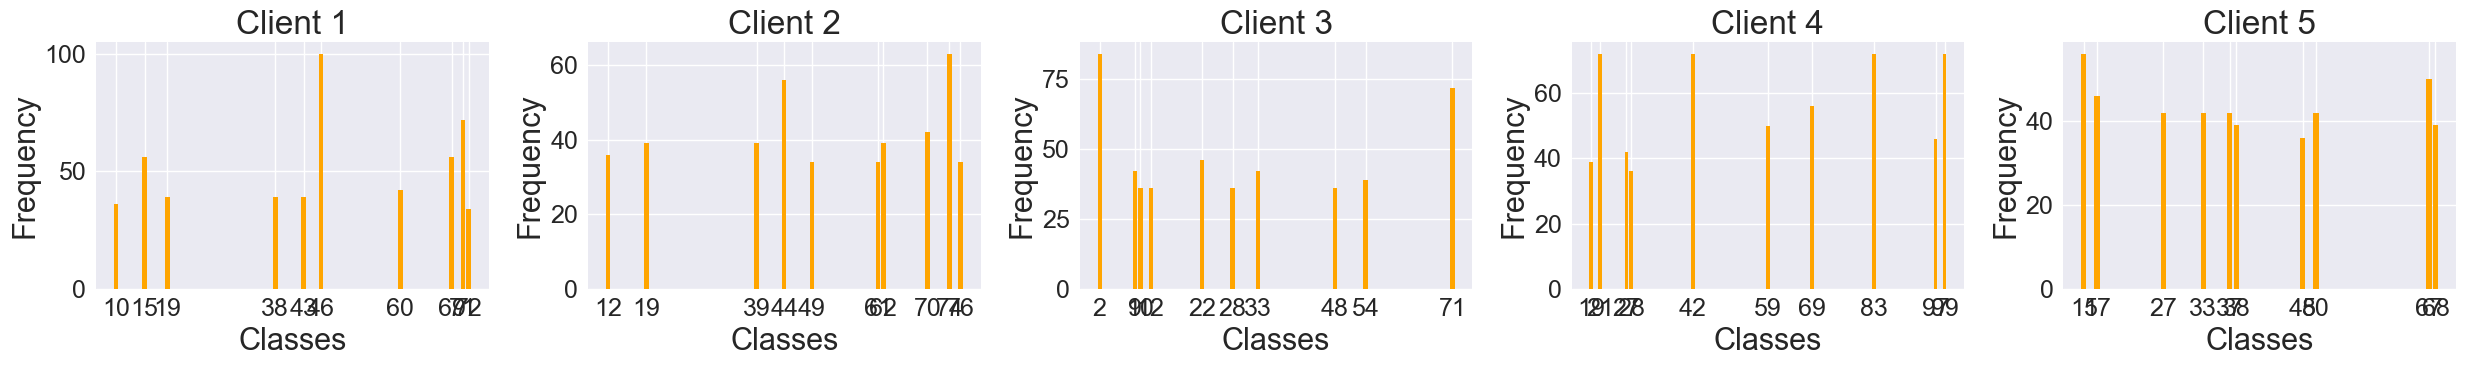

In [ ]:
""" IMPORTING THE MODEL with PRE-TRAINED CLASSIFIER from OUTSIDE """

# === CREATE and LOAD MODEL on CPU ===
device_cpu = torch.device("cpu")
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_vits16 = dino_vits16.to(device_cpu)   # remains on CPU

global_model_cpu = DINOWithHead(backbone=dino_vits16, num_classes=100).to(device_cpu)
model_filename = f"global_model_FL_HEAD_{FLAG}_J{J}_Nc{Nc}.pth"
global_model_cpu.load_state_dict(torch.load(model_filename, map_location=device_cpu))
global_model_cpu.to(device_cpu)
global_model_cpu.train()

# === FREEZE only HEAD, BACKBONE TRAINABLE ===
for name, param in global_model_cpu.named_parameters():
    if name.startswith("head"):
        param.requires_grad = False
    else:
        param.requires_grad = True
global_model_cpu.head.eval()     # Head in eval mode

# === CREA LE DUE COPIE SU GPU ===
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#imported_model_calib = copy.deepcopy(global_model_cpu).to(device_gpu)
imported_model_train = copy.deepcopy(global_model_cpu).to(device_gpu)


# === IMPORTING CLIENTS ==
clients_filename = f"clients_FL_HEAD_{FLAG}_J{J}_Nc{Nc}.pkl"
with open(clients_filename, 'rb') as f:
    clients = pickle.load(f)

Client.plot_class_distribution(clients[0:5], tot_train_data)

In [ ]:
set_seeds(123)


# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()


# === TRAINING and TESTING ===
start_time = time.time()

# === CALIBRATION MASK ===
start_c_time = time.time()
print(f'Masking, selection method: {KEEP}')
calibrate_all_clients(clients, imported_model_train, device, R=C_ROUNDS, final_sparsity=SPARSITY, lr=LR, keep = KEEP)    #imported_model_calib
end_c_time = time.time()
c_time = round(end_c_time - start_c_time, 2)

# === TRAIN FL ===
best_global_model, test_losses, test_accuracies, avg_train_losses, avg_train_accuracies, client_drift = train_test_model_FL(
    global_model=imported_model_train,
    criterion=criterion,
    LR=LR,
    MOMENTUM=MOMENTUM,
    WEIGHT_DECAY=WEIGHT_DECAY,
    T_MAX=T_MAX,
    clients=clients,
    val_test_loader=test_loader,
    num_epochs=N_EP,
    C=C,
    J=J,
    checkpoint_path=checkpoint_path,
    checkpoints=True,
    verbose=VERBOSE,
    use_sparse=True     # Using sparse SGD
)
end_time = time.time()
training_time = round(end_time - start_time, 2)

# === SAVING RESULTS ===
results_FL_sparse = {
    "flag": FLAG,
    "J": J,
    "Nc": Nc,
    "epochs": N_EP,
    "c_rounds": C_ROUNDS,
    "c_time": c_time,
    "sparsity": SPARSITY,
    "avg_train_losses": avg_train_losses,
    "avg_train_accuracies": avg_train_accuracies,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies,
    "training_time_sec": training_time,
    "client_drift": client_drift
}


Masking, selection method: least
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10256003/21665664 (47.34%)
✅ Client 1 -> mask calibrated (sparsity=0.5)
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10699986/21665664 (49.39%)
✅ Client 2 -> mask calibrated (sparsity=0.5)
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10712804/21665664 (49.45%)
✅ Client 3 -> mask calibrated (sparsity=0.5)
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10740917/21665664 (49.58%)
✅ Client 4 -> mask calibrated (sparsity=0.5)
[Round = 1] Sparsity = 0.2929
Parametri attivi: 15319937/21665664 (70.71%)
[Round = 2] Sparsity = 0.5000
Parametri attivi: 10715112/21665664 (49.46%)
✅ Client 5 -> mask calibrated (sparsi

In [ ]:
# === SAVING JSON ===
json_filename = f"results_FL_FINE_TUNED_{FLAG}_J{J}_Nc{Nc}_Cal{C_ROUNDS}_S{SPARSITY}_DRIFT.json"
with open(json_filename, 'w') as f:
    json.dump(results_FL_sparse, f, indent=2)

# === SAVING WEIGHTS ===
model_filename = f"global_model_FL_FINE_TUNED_{FLAG}_J{J}_Nc{Nc}_Cal{C_ROUNDS}_S{SPARSITY}_DRIFT.pth"
torch.save(best_global_model.state_dict(), model_filename)


✅ JSON saved: results_FL_FINE_TUNED_niid_J16_Nc10_Cal2_S0.5_DRIFT.json
✅ Model saved: global_model_FL_FINE_TUNED_niid_J16_Nc10_Cal2_S0.5_DRIFT.pth


In [ ]:
json_files = {
    "IID, J4":  "results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_DRIFT.json",
    "IID, J16": "results_FL_FINE_TUNED_iid_J16_NcNone_Cal2_S0.5_DRIFT.json",
    "non-IID, Nc10, J4":  "results_FL_FINE_TUNED_niid_J4_Nc10_Cal2_S0.5_DRIFT.json",
    "non-IID, Nc10, J16": "results_FL_FINE_TUNED_niid_J16_Nc10_Cal2_S0.5_DRIFT.json"
}

# === Load JSON and extract client drift ===
all_client_drifts = {}

for key, filename in json_files.items():
    with open(filename, 'r') as f:
        data = json.load(f)
    all_client_drifts[key] = data['client_drift']


for key, drift_data in all_client_drifts.items():
    print(f"\n=== FL: {key} ===")
    num_rounds = len(drift_data)
    num_clients = len(drift_data[0])
    print(f"Number of global rounds: {num_rounds}, Clients per round: {num_clients}")

    # Compute mean drift per round
    mean_drifts = []
    for round_idx, clients_round in enumerate(drift_data):
        # compute L2 norm across all parameters per client
        client_norms = [np.mean(list(client.values())) for client in clients_round]  # average over parameters
        mean_drifts.append(np.mean(client_norms))  # mean over clients

    print("Mean client drift per round:")
    print(np.round(mean_drifts, 4))




=== FL: IID, J4 ===
Number of global rounds: 20, Clients per round: 10
Mean client drift per round:
[0.0028 0.0028 0.0028 0.0027 0.0026 0.0028 0.0027 0.0026 0.0025 0.0026
 0.0025 0.0027 0.0026 0.0026 0.0025 0.0026 0.0025 0.0025 0.0026 0.0026]

=== FL: IID, J16 ===
Number of global rounds: 20, Clients per round: 10
Mean client drift per round:
[0.0077 0.008  0.0075 0.0072 0.0068 0.0076 0.007  0.0069 0.0062 0.0066
 0.0063 0.0069 0.0065 0.0066 0.006  0.0064 0.0057 0.0055 0.0061 0.0059]

=== FL: non-IID, Nc10, J4 ===
Number of global rounds: 20, Clients per round: 10
Mean client drift per round:
[0.0072 0.0067 0.0063 0.0058 0.0053 0.0055 0.0051 0.0054 0.0049 0.0053
 0.0051 0.0054 0.0051 0.0049 0.0047 0.0048 0.0044 0.0045 0.0045 0.0048]

=== FL: non-IID, Nc10, J16 ===
Number of global rounds: 20, Clients per round: 10
Mean client drift per round:
[0.0094 0.0088 0.0081 0.0079 0.0071 0.0078 0.0071 0.0074 0.007  0.0071
 0.0076 0.0072 0.0074 0.0069 0.0066 0.0068 0.0064 0.007  0.0064 0.0064]


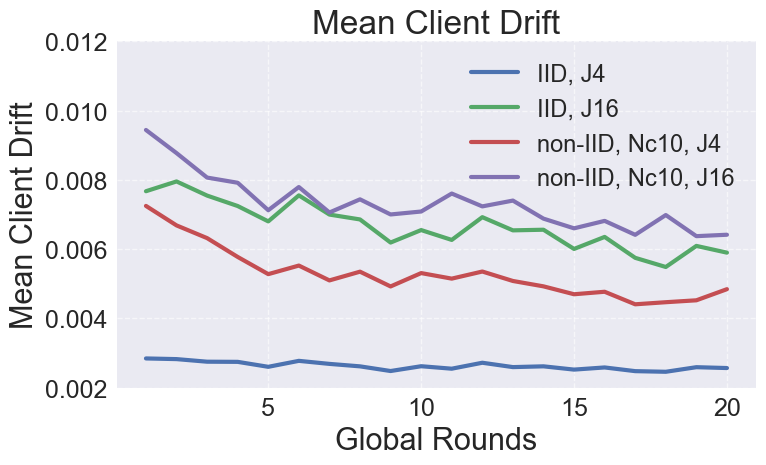

In [ ]:
all_mean_drifts = {}

# === Compute mean drift per round for each scenario ===
for key, drift_data in all_client_drifts.items():
    mean_drifts = []
    for round_idx, clients_round in enumerate(drift_data):
        client_norms = [np.mean(list(client.values())) for client in clients_round]

        # Then compute the mean drift across all clients in this round
        mean_drifts.append(np.mean(client_norms))

    # Store the drift curve for this scenario
    all_mean_drifts[key] = mean_drifts


# === Plot ===
plt.figure(figsize=(8,5))

for key, mean_drifts in all_mean_drifts.items():
    plt.plot(range(1, len(mean_drifts)+1), mean_drifts, label=key)


plt.xlabel("Global Rounds")
plt.ylabel("Mean Client Drift")
plt.ylim(0.002, 0.012)
plt.title("Mean Client Drift")
plt.legend(fontsize=17)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
